In [1]:
%matplotlib inline

import sys
import os
import io
from time import time

import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageColor, ImageFont, ImageMath
from matplotlib import pyplot as plt

import torch
import torchvision
from torchvision.ops import nms

from retinanet.utils import BasicBlock, Bottleneck, BBoxTransform, ClipBoxes
from retinanet.anchors import Anchors

from retinanet import transforms as detection_aug

from trt_toolkit import *

In [2]:
img_path = './data/1a375421-9b33-40fa-8750-8cb3dd9b2079.jpg'
test_loops = 1

batch_size = 1

## TRT test

In [3]:
from trt_toolkit import *

In [4]:
# convert model: python /opt/intel/openvino/deployment_tools/model_optimizer/mo.py --input_model det_net.onnx --data_type FP16 --reverse_input_channels

IMAGE_SIZE = 512
NMS_THRESHOLD = 0.5
SCORE_THRESHOLD = 0.3
MAX_DETECTIONS = 12

CLASSES = {
    'root': 0,
    'tooth': 1,
    'treated-root': 2,
    'treated-tooth': 3,
    'uncertain': 4
}

# TRT consts
fp16_mode = False

onnx_file = './det_net.onnx'
engine_file = './det_net.trt'

num_classes = 6

In [5]:
class PreProcessor():
    def __init__(self, image_size):
        self.image_size = image_size
        self.detect_trans = detection_aug.Compose([
            detection_aug.Pad(),
            detection_aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
            detection_aug.AutoLevel(min_level_rate=1, max_level_rate=1),
            detection_aug.AutoContrast(),
            detection_aug.Contrast(1.25),
            detection_aug.ToTensor()
        ])
        
    def process(self, img):
        data = self.detect_trans(img, (torch.tensor([]), torch.tensor([]), {}))
        
        scale = data[1][2]["scale"]
        pad_loc = data[1][2]["pad_loc"]
        
        return data[0].numpy(), scale, pad_loc

In [6]:
class PostProcessor():
    def __init__(self, nms, score):
        self.anchors = Anchors()
        self.regressBoxes = BBoxTransform()
        self.clipBoxes = ClipBoxes()
        self.nms = nms
        self.score_threshold = score
        
    def process(self, img_batch, regression, classification):
        anchors = self.anchors(img_batch)

        transformed_anchors = self.regressBoxes(anchors, regression)
        transformed_anchors = self.clipBoxes(transformed_anchors, img_batch)

        scores = torch.max(classification, dim=2, keepdim=True)[0]
        scores_over_thresh = (scores>0.05)[0, :, 0]

        if scores_over_thresh.sum() == 0:
            # no boxes to NMS, just return
            return [torch.zeros(0), torch.zeros(0), torch.zeros(0, 4)]

        classification = classification[:, scores_over_thresh, :]
        transformed_anchors = transformed_anchors[:, scores_over_thresh, :]
        scores = scores[:, scores_over_thresh, :]

        anchors_nms_idx = nms(transformed_anchors[0, :, :], scores[0, :, :].squeeze(), self.nms)

        nms_scores, nms_class = classification[0, anchors_nms_idx, :].max(dim=1)

        return [nms_scores, nms_class, transformed_anchors[0, anchors_nms_idx, :]]
    
    def export(self, scores, labels, boxes, scale, pad_loc):
        # correct boxes
        '''
        w_scale = w / ori_w
        h_scale = h / ori_h
        boxes[:, 0::2] /= w_scale
        boxes[:, 1::2] /= h_scale
        '''
        
        boxes /= scale
        for box in boxes:
            box[1] -= pad_loc[0]
            box[3] -= pad_loc[0]
            box[0] -= pad_loc[2]
            box[2] -= pad_loc[2]
        
        # SCORE_THRESHOLD
        indices = np.where(scores > SCORE_THRESHOLD)[0]

        if indices.shape[0] > 0:
            scores = scores[indices]
            scores_sort = np.argsort(-scores)[:MAX_DETECTIONS]

            image_boxes = boxes[indices[scores_sort], :]
            image_scores = scores[scores_sort]
            image_labels = labels[indices[scores_sort]]

            image_detections = []

            for box, label in zip(image_boxes, image_labels):
                if label == CLASSES['treated-root']:
                    image_detections.append(box.tolist())

            return image_detections

        return []

In [7]:
trt_logger = trt.Logger()

engine = create_trt_engine(
    trt_logger,
    onnx_file,
    engine_file,
    batch_size=batch_size,
    fp16_mode=fp16_mode,
    save_engine=True
)

# create context
context = engine.create_execution_context()

# allocate host buffers
inputs, outputs, bindings, stream, output_shapes = allocate_buffers(engine)

# create pre/post-processor
pre_processor = PreProcessor(IMAGE_SIZE)
post_processor = PostProcessor(NMS_THRESHOLD, SCORE_THRESHOLD)

# prepare data
img = cv2.imread(img_path)
ori_h, ori_w, _ = img.shape

img, scale, pad_loc = pre_processor.process(img)

# create batch
imgs = np.expand_dims(img, axis=0)
imgs = imgs.astype(np.float32)

In [8]:
# infer
t0 = cv2.getTickCount()

for i in range(test_loops):
    inputs[0].host = imgs.reshape(-1)
    
    outs = infer(
        context,
        bindings=bindings,
        inputs=inputs,
        outputs=outputs,
        stream=stream
    )
    
    results = [post_process(outs[i], output_shapes[i]) for i in range(len(outs))]
    
infer_time = (cv2.getTickCount() - t0) / cv2.getTickFrequency()

# post process
t0 = cv2.getTickCount()

for i in range(test_loops):
    regression, classification = results

    regression = torch.from_numpy(regression)
    classification = torch.from_numpy(classification)

    img_batch = torch.from_numpy(img).unsqueeze(0)

    scores, labels, boxes = post_processor.process(img_batch, regression, classification)
    dets = post_processor.export(scores, labels, boxes, scale, pad_loc)

post_process_time = (cv2.getTickCount() - t0) / cv2.getTickFrequency()

print('infer time: {}, post process time: {}'.format(infer_time, post_process_time))

infer time: 0.016869903, post process time: 0.005662614


In [9]:
print(dets)

[[122.29097747802734, 89.08790588378906, 295.6843566894531, 275.4416809082031], [336.2323913574219, 126.95733642578125, 502.2923583984375, 364.0016784667969]]


## draw results

In [10]:
BBOX_COLOR_NAME = 'blue'
SCORE_COLOR_NAME = 'lime'
BBOX_LINE_WIDTH = 2

def _convert_I16_to_L(i16_img):
    im2 = ImageMath.eval('im/256', {'im':i16_img}).convert('L')

    return im2

def draw_score_bboxes(picture_path, score_bboxes, bbox_color_name=BBOX_COLOR_NAME, score_color_name=SCORE_COLOR_NAME, bbox_line_width=BBOX_LINE_WIDTH, draw_score=True):
    img = Image.open(picture_path)
    
    if img.mode == 'I':
        img = _convert_I16_to_L(img)

    img = img.convert('RGB')

    draw = ImageDraw.Draw(img)

    for score_bbox in score_bboxes:
        bbox = score_bbox[:4]

        draw.rectangle(
            bbox,
            outline=ImageColor.getrgb(bbox_color_name),
            width=bbox_line_width
        )

        if draw_score:
            score = score_bbox[4]
            
            draw.text(
                bbox[:2],
                '{:.2f}'.format(score),
                # font=self.font,
                fill=ImageColor.getrgb(score_color_name)
            )

    del draw

    # img.save(imgArr, format='JPEG')
    fig=plt.figure(figsize=(16,12))
    plt.imshow(np.asarray(img))
    plt.show()

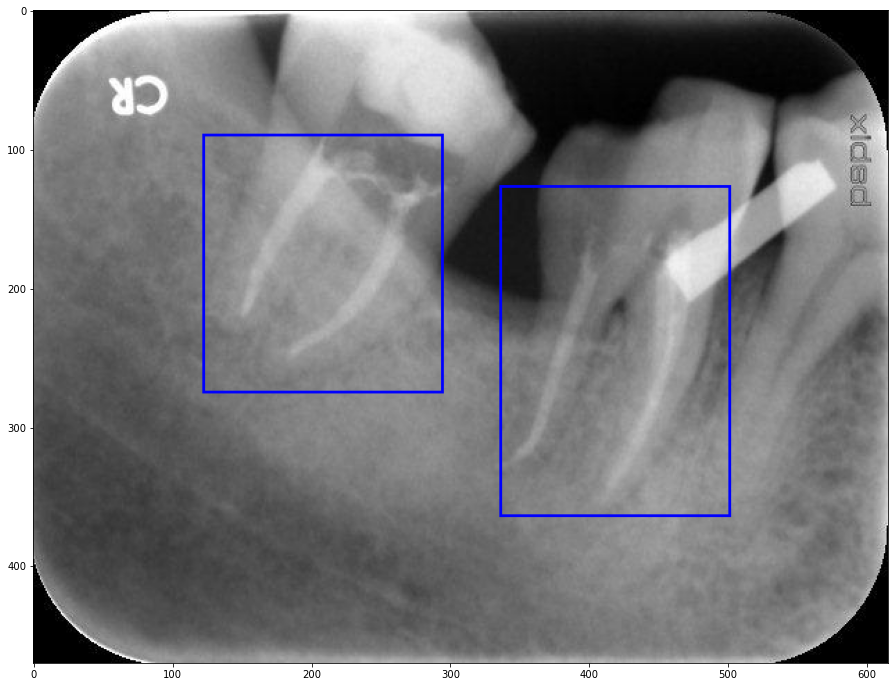

In [11]:
draw_score_bboxes(img_path, dets, draw_score=False)